In [33]:
import os

In [34]:
import pandas as pd 
import numpy as np 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
#plotly imports
import sys 
#conda install --yes --prefix {sys.prefix} plotly
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
warnings.filterwarnings('ignore')

In [35]:
data = pd.read_excel('OppScrData.xlsx')

In [36]:
clin_data = data.iloc[:, 2:14]
clin_out = data.iloc[:, 15:]

In [37]:
#Cleaning Clinical outcome data with CT data 


#Copying and adding PT_ID to clinical outcome dataframe
#This will help to identify inidividual people 
clin_out['PT ID'] = clin_data['PT ID'].values
clin_out.dtypes

#Changing some DX features into boolean (if the have heartfailure, Type 2 Diabetes, ect)
def switch_to_bool(df, col, new_col_name):
    temp = []
    df[col] = df[col].fillna(0)
    for i in df[col]:
        if i == 0:
            temp.append(0) 
        else:
            temp.append(1)
           
    df[new_col_name] = temp
    del df[col]
    return df


switch_to_bool(clin_out, "Heart failure DX", "Bool Heart failure DX")
switch_to_bool(clin_out, "DEATH [d from CT]", "Bool Death")
switch_to_bool(clin_out, "Type 2 Diabetes DX", "Bool Diabetes")
switch_to_bool(clin_out, "Femoral neck fracture DX", "Bool Neck Fracture")
switch_to_bool(clin_out, "Alzheimers DX", "Bool Alzheimers")
switch_to_bool(clin_out, "Primary Cancer Site", "Bool Primary Cancer")
switch_to_bool(clin_out, "MI DX", "Bool MI")
switch_to_bool(clin_out, "CVD DX", "Bool CVD")

#Dropping columns with high nan values. 
clin_out = clin_out.loc[:, clin_out.isnull().mean() < .2]
print(len(clin_out.columns))

del clin_out['Liver HU    (Median)']
clin_out.dtypes
#changing nan values to means 
for (col_name, col_data) in clin_out.iteritems():
    clin_out[col_name].fillna(value = clin_out[col_name].mean(), inplace = True)

scaler = StandardScaler()
nume = clin_out.iloc[:, :10]
temp_col = [col for col in nume.columns]
print(temp_col)
cat = clin_out.iloc[:, 10:]
nume = pd.DataFrame(scaler.fit_transform(nume))
nume.columns = temp_col


#reorganizing with ID and death label at front
clin_out = pd.concat([nume, cat], axis = 1, join = 'inner')
death = clin_out.pop("Bool Death")
clin_out.insert(0, "Death", death)
pt_id = clin_out.pop("PT ID")
clin_out.insert(1, "PT ID", pt_id)
clin_out.head()

20
['L1_HU_BMD', 'TAT Area (cm2)', 'Total Body                Area EA (cm2)', 'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU', ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston']


,Death,PT ID,L1_HU_BMD,TAT Area (cm2),Total Body Area EA (cm2),VAT Area (cm2),SAT Area (cm2),VAT/SAT Ratio,Muscle HU,Muscle Area (cm2),L3 SMI (cm2/m2),AoCa Agatston,Bool Heart failure DX,Bool Diabetes,Bool Neck Fracture,Bool Alzheimers,Bool Primary Cancer,Bool MI,Bool CVD
0,1,6669,-0.858268,5.785108e-15,1.038633e-15,-1.424481e-15,5.442106e-15,-2.203971e-15,-0.882568,0.342100,0.472440,2.731925,0,1,0,0,1,1,0
1,1,2915,0.494354,5.773983e-01,1.009842e-01,8.775709e-02,8.995944e-01,-4.249055e-01,-1.055635,-0.662651,-0.356659,1.150192,0,0,0,0,1,0,0
2,0,5321,2.013088,6.017792e-01,1.545994e-01,-1.109756e-01,1.170917e+00,-6.009353e-01,-0.461124,-0.387995,-0.220829,-0.399825,0,0,0,0,1,0,0
3,1,1934,-0.526045,-4.745818e-01,-4.006919e-01,-2.421496e-01,-6.025996e-01,1.207726e-01,0.156443,1.263110,1.309101,1.080109,0,0,0,0,1,1,0
4,1,1817,-1.546444,-3.330499e-01,-3.805787e-01,2.449719e-01,-9.079087e-01,1.247549e+00,-2.654595,0.317480,-0.404823,-0.152927,0,1,0,0,0,0,0


In [38]:
#Isolating CT data with the death label for comparison. 
ct_data = clin_out.copy(deep = True)
ct_data2 = clin_out.copy(deep = True)
del ct_data["Bool Diabetes"]
del ct_data["Bool Heart failure DX"]
del ct_data["Bool Neck Fracture"]
del ct_data["Bool Alzheimers"]
del ct_data["Bool Primary Cancer"]
del ct_data["Bool MI"]
del ct_data["Bool CVD"]

ct_data.head()

,Death,PT ID,L1_HU_BMD,TAT Area (cm2),Total Body Area EA (cm2),VAT Area (cm2),SAT Area (cm2),VAT/SAT Ratio,Muscle HU,Muscle Area (cm2),L3 SMI (cm2/m2),AoCa Agatston
0,1,6669,-0.858268,5.785108e-15,1.038633e-15,-1.424481e-15,5.442106e-15,-2.203971e-15,-0.882568,0.342100,0.472440,2.731925
1,1,2915,0.494354,5.773983e-01,1.009842e-01,8.775709e-02,8.995944e-01,-4.249055e-01,-1.055635,-0.662651,-0.356659,1.150192
2,0,5321,2.013088,6.017792e-01,1.545994e-01,-1.109756e-01,1.170917e+00,-6.009353e-01,-0.461124,-0.387995,-0.220829,-0.399825
3,1,1934,-0.526045,-4.745818e-01,-4.006919e-01,-2.421496e-01,-6.025996e-01,1.207726e-01,0.156443,1.263110,1.309101,1.080109
4,1,1817,-1.546444,-3.330499e-01,-3.805787e-01,2.449719e-01,-9.079087e-01,1.247549e+00,-2.654595,0.317480,-0.404823,-0.152927


In [39]:
#Now cleaning clinical data

#Converting catigorical to bianary
gender = {'Male':1, 'Female':0}
clin_data.Sex = [gender[item] for item in clin_data.Sex]

tabac = {'Yes':1, 'Y':1, 'N':0, 'No':0, 0:0}
clin_data['Tobacco'] = clin_data['Tobacco'].fillna(0)
clin_data.Tobacco = [tabac[item] for item in clin_data.Tobacco]

switch_to_bool(clin_data, "Alcohol abuse", "Bool Alcohol abuse")
clin_data.head()

   
clin_data["Met Sx"] = clin_data["Met Sx"].fillna(0)
met = {'Yes':1, 'Y':1, 'N':0, 'No':0, 0:0}
clin_data['Met_Sx']= [met[item] for item in clin_data['Met Sx']]
del clin_data["Met Sx"]
clin_data.head()
clin_data = clin_data.drop(['BMI >30'], axis = 1)
sex = clin_data.pop("Sex")
clin_data.insert(1, "Sex", sex)
tbc = clin_data.pop("Tobacco")
clin_data.insert(1, "Tobacco", tbc)
alc = clin_data.pop("Bool Alcohol abuse")
clin_data.insert(1, "Alcohol abuse", alc)
met = clin_data.pop("Met_Sx")
clin_data.insert(1, "Met Sx", met)
clin_data.head()
#Changing out random nan strings for 0, and keeping float values 

def switch_to_bool(df, col, new_col_name):
    temp = []
    
    for i in df[col]:
        if type(i) == str:
            temp.append(0) 
        else:       
            temp.append(i)
    del df[col]      
    df[new_col_name] = temp
    return df

switch_to_bool(clin_data, "FRS 10-year risk (%)", "10 year risk")
switch_to_bool(clin_data, "FRAX 10y Hip Fx Prob (Orange-w/ DXA)", "FRAX 10y Hip Fx Prob (Orange-w/ DXA)")
switch_to_bool(clin_data, "FRAX 10y Fx Prob (Orange-w/ DXA)", "FRAX 10y Fx Prob (Orange-w/ DXA)")

for (col_name, col_data) in clin_data.iteritems():
    clin_data[col_name].fillna(value = clin_data[col_name].mean(), inplace = True)
    
scaler = StandardScaler()
nume = clin_data.iloc[:, 5:]
temp_col = [col for col in nume.columns]
print(temp_col)
cat = clin_data.iloc[:, :5]
nume = pd.DataFrame(scaler.fit_transform(nume))
nume.columns = temp_col
clin_data = pd.concat([cat, nume], axis = 1, join = 'inner')
clin_data.head()

['Clinical F/U interval  [d from CT]', 'BMI', 'Age at CT', '10 year risk', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'FRAX 10y Fx Prob (Orange-w/ DXA)']


,PT ID,Met Sx,Alcohol abuse,Tobacco,Sex,Clinical F/U interval [d from CT],BMI,Age at CT,10 year risk,FRAX 10y Hip Fx Prob (Orange-w/ DXA),FRAX 10y Fx Prob (Orange-w/ DXA)
0,6669,0,0,0,1,-1.369576,1.362777,2.031816,-0.807491,0.127132,-0.246855
1,2915,0,0,0,0,-1.739467,0.193007,-0.267439,-0.807491,-0.299910,-0.134296
2,5321,0,0,0,0,-1.703693,-0.114827,-0.650648,-0.807491,-0.333186,-0.375887
3,1934,0,0,1,1,-0.407049,-0.591970,0.371243,0.644261,-0.033702,-0.010755
4,1817,0,0,1,1,-1.622695,-0.992154,3.947862,3.063848,4.208988,1.688614


In [40]:
#Making a combined clin_data and clin_out dataset for goal 2
#Inner joining based on PT ID 

merged = pd.merge(clin_data, clin_out, on = 'PT ID', how = 'inner')
merged.head()

,PT ID,Met Sx,Alcohol abuse,Tobacco,Sex,Clinical F/U interval [d from CT],BMI,Age at CT,10 year risk,FRAX 10y Hip Fx Prob (Orange-w/ DXA),...,Muscle Area (cm2),L3 SMI (cm2/m2),AoCa Agatston,Bool Heart failure DX,Bool Diabetes,Bool Neck Fracture,Bool Alzheimers,Bool Primary Cancer,Bool MI,Bool CVD
0,6669,0,0,0,1,-1.369576,1.362777,2.031816,-0.807491,0.127132,...,0.342100,0.472440,2.731925,0,1,0,0,1,1,0
1,2915,0,0,0,0,-1.739467,0.193007,-0.267439,-0.807491,-0.299910,...,-0.662651,-0.356659,1.150192,0,0,0,0,1,0,0
2,5321,0,0,0,0,-1.703693,-0.114827,-0.650648,-0.807491,-0.333186,...,-0.387995,-0.220829,-0.399825,0,0,0,0,1,0,0
3,1934,0,0,1,1,-0.407049,-0.591970,0.371243,0.644261,-0.033702,...,1.263110,1.309101,1.080109,0,0,0,0,1,1,0
4,1817,0,0,1,1,-1.622695,-0.992154,3.947862,3.063848,4.208988,...,0.317480,-0.404823,-0.152927,0,1,0,0,0,0,0


In [41]:
y = merged["Death"]
del merged["Death"]
X = merged.iloc[:, 1:]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [42]:
print(merged.columns)

Index(['PT ID', 'Met Sx', 'Alcohol abuse', 'Tobacco', 'Sex',
       'Clinical F/U interval  [d from CT]', 'BMI', 'Age at CT',
       '10 year risk', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Fx Prob (Orange-w/ DXA)', 'L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Bool Heart failure DX', 'Bool Diabetes', 'Bool Neck Fracture',
       'Bool Alzheimers', 'Bool Primary Cancer', 'Bool MI', 'Bool CVD'],
      dtype='object')


# Goal 3: Derive a patient’s biological age (i.e., relative to actual chronological age) using CT data. 
(The date of the CT scan is day zero, and all other dates are now in days relative to the date of CT).

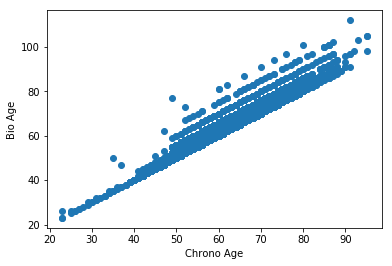

In [43]:
data = pd.read_excel('OppScrData.xlsx')




ct_data2 = clin_out.copy(deep = True)
#add a "bio age" feature which is the combination of clinical outcomes
#Idea: The more negative health DX, the highter the bio age
ct_data2["bio age"] = ct_data2["Death"] + ct_data2["Bool Diabetes"] + ct_data2["Bool Heart failure DX"]+ct_data2["Bool Neck Fracture"]+ct_data2["Bool Alzheimers"]+ct_data2["Bool Primary Cancer"]+ct_data2["Bool MI"]+ct_data2["Bool CVD"]




del ct_data2["Bool Diabetes"]
del ct_data2["Bool Heart failure DX"]
del ct_data2["Bool Neck Fracture"]
del ct_data2["Bool Alzheimers"]
del ct_data2["Bool Primary Cancer"]
del ct_data2["Bool MI"]
del ct_data2["Bool CVD"]
del ct_data2["Death"]





weight = {0:0, 1:1, 2:1.5, 3:2, 4:2.5, 5:3, 6:3.5, 7:4}
new_bio = []
for i in ct_data2['bio age']:
    val = weight[i]
    new_bio.append(i*val)

ct_data2['new_bioage'] = new_bio
ct_data2.head()



data = pd.read_excel('OppScrData.xlsx')



pt_id = data.pop("PT ID")
data.insert(0, "PT ID", pt_id)
age = data.pop("Age at CT")
data.insert(0, "age", age)



Age = data.iloc[:, 0:2]
Age.head()
ct = pd.merge(Age, ct_data2, on = 'PT ID', how = 'inner')



age_sum = ct['age'] + ct["new_bioage"]
ct['age_sum'] = age_sum
#ct.head()



#print(max(ct['age_sum']))




#multiply, and add age
#scale between 0 and 100 then bin
x = ct["age"]
y = ct["age_sum"]



pop1 = ct.pop("age")
pop2 = ct.pop("bio age")
pop3 = ct.pop("new_bioage")



plt.scatter(x, y)
#plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.ylabel('Bio Age')
plt.xlabel('Chrono Age')
plt.show()

In [44]:
bins = [20, 30, 50, 70, 80, 120]
labels = [1,2,3,4,5]
ct['binned'] = pd.cut(ct['age_sum'], bins, labels=labels)

In [45]:
X = ct.iloc[:, 1:11]
y = ct["binned"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)

# CT DATA ONLY 

In [46]:
X = ct.iloc[:, 1:11]
y = ct["age_sum"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)

linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred=linreg.predict(X_test)

# y_pred = y_pred.to_numpy()
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)


mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Linear regression is "+str(mse))


 Mse Linear regression is 45.79299134336981


In [47]:
from sklearn.tree import DecisionTreeRegressor

X = ct.iloc[:, 1:11]
y = ct["age_sum"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)

# Build decision tree
tree=DecisionTreeRegressor(max_depth=3)
tree.fit(X_train,y_train)

y_pred=tree.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Decision Tree regression is "+str(mse))

 Mse Decision Tree regression is 52.26252459565863


In [48]:
from sklearn.ensemble import RandomForestRegressor

X = ct.iloc[:, 1:11]
y = ct["age_sum"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)

# define used regressor
forest=RandomForestRegressor(n_estimators=20,
                             max_depth=10,
                             criterion='mse',
                            )

# train model
forest.fit(X_train,y_train)
y_pred= forest.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Decision Tree regression is "+str(mse))

 Mse Decision Tree regression is 42.31052940275538


In [49]:
del merged["Bool Diabetes"]
del merged["Bool Heart failure DX"]
del merged["Bool Neck Fracture"]
del merged["Bool Alzheimers"]
del merged["Bool Primary Cancer"]
del merged["Bool MI"]
del merged["Bool CVD"]
del merged['Age at CT']
X = merged.iloc[:, 1:]
y = ct["age_sum"]

Index(['Met Sx', 'Alcohol abuse', 'Tobacco', 'Sex',
       'Clinical F/U interval  [d from CT]', 'BMI', '10 year risk',
       'FRAX 10y Hip Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Fx Prob (Orange-w/ DXA)', 'L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston'],
      dtype='object')


# CT DATA AND CLINICAL DATA ONLY 

In [50]:
# linear regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)

linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred=linreg.predict(X_test)

y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Linear regression is "+str(mse))

 Mse Linear regression is 25.343886055141528


In [51]:
# decision tree
from sklearn.tree import DecisionTreeRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)

# Build decision tree
tree=DecisionTreeRegressor(max_depth=3)
tree.fit(X_train,y_train)

y_pred=tree.predict(X_test)

y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Decision Tree regression is "+str(mse))

 Mse Decision Tree regression is 32.78380348785326


In [53]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)

# define used regressor
forest=RandomForestRegressor(n_estimators=20,
                             max_depth=10,
                             criterion='mse',
                            )

# train model
forest.fit(X_train,y_train)
y_pred= forest.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0],1)
mse = (np.linalg.norm(y_pred-y_test)**2)/len(y_pred)
print(" Mse Decision Tree regression is "+str(mse))

 Mse Decision Tree regression is 16.391346306362113
